In [57]:
#pip install gensim matplotlib wordcloud spacy pyLDAvis

In [58]:
#python3 -m spacy download en

A document is a control statement. The corpus of these documents includes all controls across all SSPS (AC-1 from SSP3, AC-2 from SSP1). The goal is to find the topics(components) from this wider corpus. We can imagine like controls like all the AC-1 will form a component and that AC-2 might actually be a component with AU-3(not sure if actually just for example)

In [380]:
%matplotlib inline

import pprint
import os
import spacy
import pyLDAvis
import pyLDAvis.gensim  

In [60]:
def remove_extra(doctext):
    """
    Remove extra markdown characters that are not to be used in the analysis
    """
    
    doc = doctext.replace('# Reusable Component Library System Security Plan', "").replace('```text', "").replace('```', '').replace("'", "").replace('*', "")
    return doc

In [485]:
def read_markdown(filename):
    """
    Read in a file as one string with markdown characters removed
    """
    
    file_string = """{}""".format(open(f'{root}/{filename}', encoding="utf8").read())
    # Remove extra markdown characters
    clean_file_string = remove_extra(file_string)
    return clean_file_string


In [569]:
def remove_stopwords(texts):
    # Create a set of frequent words that add no value to our analysis
    # at the moment this is optional despite its use here
    stop_words = set("for a of the and to in as are or and/or * # ## ### #### ##### – - 1. 2. 3. 4. 1 2 3 4 a. b. c. d. a b c d".split(' '))
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

   # return [[word for word in document.lower().split() if word not in stoplist] for document in texts]


def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [564]:
import os
# Folder with controls
root = f"{os.getcwd()}/docs/controls"

# control corpus
text_corpus = []
for filename in os.listdir(root):
    # Assign variable names dynamically
    name = ''.join(filename).replace(".", "_")
    data = read_markdown(filename)
    text_corpus.append(data)

In [566]:
def clean(text):
    return str(''.join([i if ord(i) < 128 else ' ' for i in text]))

In [567]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(text_corpus))
#print(data_words)


[['nist', 'sp', 'revision', 'ac', 'access', 'control', 'ac', 'access', 'control', 'policy', 'and', 'procedures', 'the', 'organization', 'develops', 'documents', 'and', 'disseminates', 'to', 'assignment', 'organization', 'defined', 'personnel', 'or', 'roles', 'an', 'access', 'control', 'policy', 'that', 'addresses', 'purpose', 'scope', 'roles', 'management', 'commitment', 'coordination', 'among', 'organizational', 'entities', 'and', 'compliance', 'and', 'procedures', 'to', 'facilitate', 'the', 'implementation', 'of', 'the', 'access', 'control', 'policy', 'and', 'associated', 'access', 'controls', 'and', 'reviews', 'and', 'updates', 'the', 'current', 'access', 'control', 'policy', 'assignment', 'organization', 'defined', 'frequency', 'and', 'access', 'control', 'procedures', 'assignment', 'organization', 'defined', 'frequency', 'status', 'complete', 'civicactions', 'civicactions', 'has', 'developed', 'documented', 'and', 'disseminated', 'to', 'personnel', 'an', 'access', 'control', 'poli

# Build the bigram and trigram models


In [568]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [570]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)#text_corpus

#Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# Count word frequencies
from collections import defaultdict
frequency = defaultdict(int)
for text in data_lemmatized:
    for token in text:# doc_to_words(text)
        token = "".join(token)
        frequency[token] += 1

# Only keep words that appear more than once
processed_corpus = [[token for token in text if frequency[token] > 1] for text in data_lemmatized]
#pprint.pprint(processed_corpus)

## Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

In [571]:
from gensim import corpora
# Create Dictionary

dictionary = corpora.Dictionary(data_lemmatized)#processed_corpus
#pprint.pprint(dictionary.token2id)

{'abide': 1444,
 'ability': 0,
 'able': 1159,
 'above': 1568,
 'abuse': 1317,
 'ac': 1,
 'accept': 931,
 'acceptable': 586,
 'acceptance': 507,
 'access': 2,
 'accessible': 1415,
 'accommodate': 669,
 'accommodation': 3,
 'accomplish': 4,
 'accord': 5,
 'accordance': 6,
 'accordingly': 1318,
 'account': 7,
 'accountability': 508,
 'accountable': 509,
 'accounting': 510,
 'accreditation': 8,
 'accuracy': 9,
 'accurate': 511,
 'accurately': 932,
 'achieve': 933,
 'acknowledge': 10,
 'acknowledgement': 1445,
 'acknowledgment': 934,
 'acquisition': 512,
 'act': 11,
 'action': 12,
 'activate': 13,
 'activation': 1160,
 'activity': 14,
 'actual': 1161,
 'ad': 587,
 'add': 935,
 'addition': 670,
 'additional': 15,
 'additionally': 16,
 'address': 485,
 'adequate': 671,
 'adhere': 1299,
 'adherence': 672,
 'adjust': 1319,
 'admin': 673,
 'administer': 17,
 'administration': 18,
 'administrative': 19,
 'administrator': 20,
 'adopt': 1466,
 'advanced': 1712,
 'advice': 1320,
 'advisory': 1713,
 

 'login': 777,
 'login_attempt': 256,
 'login_link': 1222,
 'logon': 257,
 'logout': 778,
 'logs': 893,
 'long': 553,
 'lose': 1223,
 'loss': 1146,
 'low': 1224,
 'lower': 1741,
 'machine': 1080,
 'magnitude': 1547,
 'mail': 779,
 'mailbox': 1225,
 'mailing': 1625,
 'maintain': 258,
 'maintain_pii': 554,
 'maintenance': 499,
 'major': 629,
 'make': 259,
 'malicious': 1742,
 'malicious_code': 1743,
 'manage': 260,
 'management': 261,
 'manager': 262,
 'managing': 1345,
 'mandate': 555,
 'mandatory': 995,
 'manipulation': 780,
 'manner': 1147,
 'manual': 1495,
 'manually': 556,
 'manufacture': 996,
 'manufacturer': 1392,
 'many': 1626,
 'map': 781,
 'master': 1432,
 'match': 1128,
 'material': 630,
 'matrix_available': 1393,
 'mature': 1346,
 'maximize': 1129,
 'maximum': 263,
 'may': 264,
 'mean': 1081,
 'measure': 265,
 'measurement': 1744,
 'mechanism': 782,
 'media_protection': 1413,
 'mediate': 1689,
 'medium': 631,
 'meet': 632,
 'meeting': 894,
 'member': 266,
 'membership': 267,


 'will': 481,
 'window': 482,
 'wireless': 483,
 'work': 484,
 'workflow': 1375,
 'workforce': 667,
 'workstation': 668,
 'world': 1120,
 'would': 1296,
 'write': 1050,
 'www': 1297,
 'year': 585,
 'zip': 1298,
 'zone': 1709}


# example of term document frequency

In [333]:
new_doc = "Access 800-53"
new_vec = dictionary.doc2bow(new_doc.lower().split())
#print(new_vec)

[(0, 1)]


## convert our entire processed corpus to a list of vectors (word_id, word_frequency):

In [572]:
# Term Document Frequency
bow_corpus = [dictionary.doc2bow(text) for text in data_lemmatized]
#pprint.pprint(bow_corpus)

[[(0, 1),
  (1, 1),
  (2, 93),
  (3, 1),
  (4, 1),
  (5, 4),
  (6, 7),
  (7, 83),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 8),
  (13, 1),
  (14, 3),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 2),
  (20, 22),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 2),
  (25, 12),
  (26, 1),
  (27, 14),
  (28, 1),
  (29, 5),
  (30, 2),
  (31, 1),
  (32, 4),
  (33, 2),
  (34, 5),
  (35, 3),
  (36, 2),
  (37, 9),
  (38, 10),
  (39, 1),
  (40, 5),
  (41, 1),
  (42, 7),
  (43, 1),
  (44, 4),
  (45, 3),
  (46, 3),
  (47, 1),
  (48, 4),
  (49, 9),
  (50, 2),
  (51, 6),
  (52, 24),
  (53, 1),
  (54, 3),
  (55, 2),
  (56, 5),
  (57, 5),
  (58, 1),
  (59, 3),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 2),
  (64, 3),
  (65, 2),
  (66, 4),
  (67, 1),
  (68, 13),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 2),
  (73, 5),
  (74, 1),
  (75, 32),
  (76, 1),
  (77, 1),
  (78, 2),
  (79, 1),
  (80, 3),
  (81, 2),
  (82, 1),
  (83, 4),
  (84, 3),
  (85, 1),
  (86, 5),
  (87, 1),
  (88, 1),
  (89, 6),
  (90, 1),


  (616, 1),
  (617, 1),
  (621, 3),
  (625, 4),
  (629, 1),
  (634, 2),
  (635, 1),
  (637, 1),
  (639, 1),
  (640, 1),
  (642, 1),
  (651, 13),
  (662, 2),
  (670, 1),
  (680, 1),
  (705, 6),
  (708, 17),
  (718, 2),
  (719, 1),
  (726, 2),
  (732, 5),
  (746, 3),
  (754, 2),
  (759, 1),
  (760, 1),
  (779, 1),
  (785, 1),
  (786, 2),
  (794, 1),
  (802, 2),
  (807, 2),
  (808, 2),
  (812, 2),
  (827, 2),
  (855, 1),
  (868, 1),
  (887, 1),
  (892, 2),
  (899, 2),
  (906, 1),
  (916, 1),
  (922, 1),
  (923, 1),
  (927, 4),
  (931, 1),
  (932, 1),
  (933, 2),
  (934, 1),
  (935, 1),
  (936, 1),
  (937, 1),
  (938, 1),
  (939, 4),
  (940, 1),
  (941, 1),
  (942, 3),
  (943, 1),
  (944, 2),
  (945, 1),
  (946, 1),
  (947, 1),
  (948, 2),
  (949, 2),
  (950, 1),
  (951, 1),
  (952, 2),
  (953, 1),
  (954, 1),
  (955, 1),
  (956, 1),
  (957, 1),
  (958, 1),
  (959, 2),
  (960, 2),
  (961, 1),
  (962, 3),
  (963, 2),
  (964, 2),
  (965, 1),
  (966, 3),
  (967, 4),
  (968, 1),
  (969, 1),
  

  (269, 1),
  (271, 2),
  (275, 7),
  (276, 1),
  (280, 1),
  (282, 3),
  (284, 1),
  (292, 3),
  (296, 1),
  (297, 12),
  (298, 2),
  (301, 3),
  (305, 23),
  (306, 5),
  (307, 2),
  (308, 2),
  (311, 1),
  (314, 7),
  (315, 2),
  (327, 10),
  (328, 39),
  (329, 1),
  (332, 8),
  (334, 2),
  (342, 12),
  (343, 11),
  (344, 1),
  (345, 2),
  (347, 19),
  (352, 2),
  (353, 12),
  (355, 2),
  (372, 3),
  (378, 10),
  (380, 1),
  (381, 9),
  (382, 1),
  (383, 3),
  (384, 1),
  (385, 2),
  (389, 12),
  (390, 1),
  (393, 12),
  (403, 35),
  (410, 1),
  (431, 1),
  (433, 2),
  (436, 5),
  (437, 30),
  (440, 22),
  (446, 1),
  (447, 5),
  (448, 1),
  (449, 2),
  (450, 7),
  (451, 5),
  (452, 7),
  (454, 1),
  (457, 2),
  (458, 1),
  (461, 14),
  (463, 5),
  (464, 6),
  (478, 1),
  (480, 1),
  (481, 3),
  (485, 3),
  (490, 3),
  (496, 1),
  (500, 2),
  (517, 5),
  (523, 1),
  (531, 1),
  (532, 2),
  (538, 1),
  (539, 2),
  (549, 1),
  (552, 1),
  (558, 2),
  (564, 1),
  (569, 4),
  (570, 2),
 

  (521, 34),
  (522, 4),
  (523, 1),
  (532, 4),
  (539, 1),
  (548, 8),
  (564, 1),
  (570, 11),
  (571, 35),
  (589, 1),
  (598, 1),
  (602, 1),
  (604, 1),
  (610, 1),
  (617, 1),
  (633, 1),
  (634, 2),
  (636, 1),
  (640, 2),
  (649, 3),
  (650, 1),
  (651, 3),
  (658, 1),
  (665, 3),
  (676, 1),
  (718, 1),
  (732, 4),
  (751, 1),
  (754, 1),
  (782, 1),
  (796, 1),
  (815, 1),
  (819, 1),
  (834, 1),
  (841, 3),
  (850, 3),
  (859, 6),
  (868, 1),
  (870, 2),
  (880, 1),
  (884, 1),
  (897, 1),
  (899, 1),
  (900, 1),
  (906, 1),
  (910, 1),
  (912, 1),
  (913, 1),
  (915, 4),
  (916, 12),
  (917, 2),
  (920, 1),
  (923, 1),
  (927, 1),
  (928, 16),
  (929, 6),
  (930, 1),
  (935, 2),
  (942, 1),
  (959, 1),
  (963, 1),
  (977, 1),
  (984, 1),
  (987, 2),
  (990, 1),
  (1010, 3),
  (1011, 1),
  (1053, 2),
  (1055, 1),
  (1058, 2),
  (1065, 1),
  (1086, 1),
  (1088, 1),
  (1117, 3),
  (1121, 1),
  (1139, 1),
  (1157, 1),
  (1159, 1),
  (1165, 1),
  (1201, 1),
  (1203, 1),
  (1209

  (463, 4),
  (478, 1),
  (480, 1),
  (487, 1),
  (490, 2),
  (491, 1),
  (493, 1),
  (501, 1),
  (503, 1),
  (504, 7),
  (520, 1),
  (523, 1),
  (548, 1),
  (601, 1),
  (767, 1),
  (818, 1),
  (829, 2),
  (858, 1),
  (883, 1),
  (906, 1),
  (922, 1),
  (949, 1),
  (992, 1),
  (1106, 1),
  (1128, 1),
  (1218, 1),
  (1239, 5),
  (1305, 1),
  (1356, 1),
  (1538, 1),
  (1561, 1),
  (1625, 1),
  (1771, 1),
  (1772, 1),
  (1773, 1),
  (1774, 1),
  (1775, 1),
  (1776, 1),
  (1777, 1),
  (1778, 1),
  (1779, 5),
  (1780, 1)]]


In [573]:
# Human readable format of corpus (term-frequency)
human_readable_corpus = [[(dictionary[id], freq) for id, freq in cp] for cp in bow_corpus[:1]]
#human_readable_corpus

[[('ability', 1),
  ('ac', 1),
  ('access', 93),
  ('accommodation', 1),
  ('accomplish', 1),
  ('accord', 4),
  ('accordance', 7),
  ('account', 83),
  ('accreditation', 1),
  ('accuracy', 1),
  ('acknowledge', 1),
  ('act', 1),
  ('action', 8),
  ('activate', 1),
  ('activity', 3),
  ('additional', 1),
  ('additionally', 1),
  ('administer', 1),
  ('administration', 1),
  ('administrative', 2),
  ('administrator', 22),
  ('agreement', 1),
  ('alarm', 1),
  ('alert', 1),
  ('align', 2),
  ('allow', 12),
  ('analyze', 1),
  ('anonymous', 14),
  ('api', 1),
  ('applicable', 5),
  ('application', 2),
  ('apply', 1),
  ('appropriate', 4),
  ('approval', 2),
  ('approve', 5),
  ('architecture', 3),
  ('area', 2),
  ('assign', 9),
  ('assignment', 10),
  ('assistant', 1),
  ('associate', 5),
  ('attach', 1),
  ('attempt', 7),
  ('attorney', 1),
  ('attribute', 4),
  ('audit', 3),
  ('auditing', 3),
  ('audits', 1),
  ('authenticate', 4),
  ('authentication', 9),
  ('authority', 2),
  ('auth

# TfidfModel

In [574]:
from gensim import models

# train the model
tfidf = models.TfidfModel(bow_corpus)

# transform the "system minors" string
words = "access security".lower().split()
#print(tfidf[dictionary.doc2bow(words)])

[(2, 0.4970848006381418), (403, 0.8677019655241879)]


In [575]:
from gensim import similarities

index = similarities.SparseMatrixSimilarity(tfidf[bow_corpus], num_features=len(dictionary.token2id)) # len(dictionary.token2id) is the number of features

and to query the similarity of our query document ``query_document`` against every document in the corpus:



In [576]:
#query_document = 'access security'.split()
query_document = data_lemmatized[0]# AC.md after all pre-processing
query_bow = dictionary.doc2bow(query_document)
sims = index[tfidf[query_bow]]
print(list(enumerate(sims)))

[(0, 0.99999744), (1, 0.1387942), (2, 0.04209767), (3, 0.08495008), (4, 0.16163144), (5, 0.07594763), (6, 0.15709268), (7, 0.08019437), (8, 0.03521914), (9, 0.03689903), (10, 0.27233127), (11, 0.06157983), (12, 0.09341411), (13, 0.09557665), (14, 0.047743537), (15, 0.047065895), (16, 0.13603939), (17, 0.1513767), (18, 0.060967885), (19, 0.13937286), (20, 0.12508523), (21, 0.030448807), (22, 0.122066975), (23, 0.056770608), (24, 0.06647543)]


How to read this output?
Document 0 has a similarity score of 0.99999744=99%(Since its just the post-processed copy of AC.md), Document 1 has a similarity score of 14%, and Document 2 has a similarity score of 4%, etc.
We can make this slightly more readable by sorting:



In [577]:
# Sorted by similiarity score
for document_number, score in sorted(enumerate(sims), key=lambda x: x[1], reverse=True):
    print(f"Document {document_number}", f"has a similiarity score of {score:.2f}")

Document 0 has a similiarity score of 1.00
Document 10 has a similiarity score of 0.27
Document 4 has a similiarity score of 0.16
Document 6 has a similiarity score of 0.16
Document 17 has a similiarity score of 0.15
Document 19 has a similiarity score of 0.14
Document 1 has a similiarity score of 0.14
Document 16 has a similiarity score of 0.14
Document 20 has a similiarity score of 0.13
Document 22 has a similiarity score of 0.12
Document 13 has a similiarity score of 0.10
Document 12 has a similiarity score of 0.09
Document 3 has a similiarity score of 0.08
Document 7 has a similiarity score of 0.08
Document 5 has a similiarity score of 0.08
Document 24 has a similiarity score of 0.07
Document 11 has a similiarity score of 0.06
Document 18 has a similiarity score of 0.06
Document 23 has a similiarity score of 0.06
Document 14 has a similiarity score of 0.05
Document 15 has a similiarity score of 0.05
Document 2 has a similiarity score of 0.04
Document 9 has a similiarity score of 0.

# Word clouds

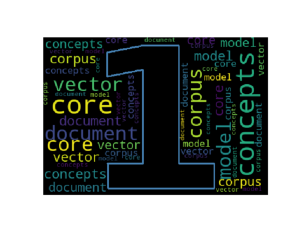

In [578]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('img/run_core_concepts.png')
imgplot = plt.imshow(img)
_ = plt.axis('off')

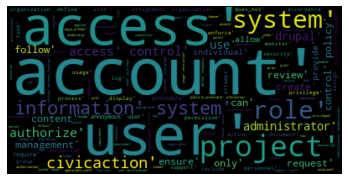

In [579]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Start with one document:
text = str(data_lemmatized[0])

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

wordcloud.to_file("img/AC_wordcloud_example.png")

# Latent Semantic Indexing:

In [580]:
from gensim import models
lsi = models.LsiModel(bow_corpus, id2word=dictionary, num_topics=2)

In [582]:
doc = text_corpus[0]# Just an example the first model will be a 100% max
vec_bow = dictionary.doc2bow(doc.lower().split())
vec_lsi = lsi[vec_bow]  # convert the query to LSI space
print(vec_lsi)

[(0, 124.08928647138222), (1, -47.124924084719)]


In [583]:
from gensim import similarities
index = similarities.MatrixSimilarity(lsi[bow_corpus])  # transform corpus to LSI space and index it

# Similiarity Query

In [584]:
sims = index[vec_lsi]  # perform a similarity query against the corpus
print(list(enumerate(sims)))  # print (document_number, document_similarity) 2-tuples

[(0, 0.99999267), (1, 0.9998268), (2, 0.83588135), (3, 0.6960639), (4, 0.90550363), (5, 0.5883225), (6, 0.8078434), (7, 0.7636117), (8, 0.9584336), (9, 0.92855406), (10, 0.93041986), (11, 0.99429667), (12, 0.6596291), (13, 0.82284194), (14, 0.775597), (15, 0.8355307), (16, 0.7207158), (17, 0.8202195), (18, 0.68748903), (19, 0.7743372), (20, 0.84945226), (21, 0.7888795), (22, 0.72959274), (23, 0.97726136), (24, 0.98280406)]


# sort

In [589]:
sims = sorted(enumerate(sims), key=lambda item: item[-1])
for doc_position, doc_score in sims:
    print(doc_score, data_lemmatized[doc_position][0])# just printing the first word in a document

(0, (24, (0, 0.99999267))) nist_sp
(1, (23, (1, 0.9998268))) nist_sp
(2, (14, (2, 0.83588135))) revision
(3, (3, (3, 0.6960639))) revision
(4, (16, (4, 0.90550363))) plan
(5, (0, (5, 0.5883225))) revision
(6, (10, (6, 0.8078434))) revision
(7, (6, (7, 0.7636117))) revision
(8, (19, (8, 0.9584336))) revision
(9, (17, (9, 0.92855406))) revision
(10, (18, (10, 0.93041986))) revision
(11, (22, (11, 0.99429667))) revision
(12, (1, (12, 0.6596291))) nist_sp
(13, (12, (13, 0.82284194))) revision
(14, (8, (14, 0.775597))) revision
(15, (13, (15, 0.8355307))) revision
(16, (4, (16, 0.7207158))) revision
(17, (11, (17, 0.8202195))) revision
(18, (2, (18, 0.68748903))) nist_sp
(19, (7, (19, 0.7743372))) revision
(20, (15, (20, 0.84945226))) policy
(21, (9, (21, 0.7888795))) nist_sp
(22, (5, (22, 0.72959274))) revision
(23, (20, (23, 0.97726136))) revision
(24, (21, (24, 0.98280406))) revision


# Many to many

For a many to many running of the above just create a model and use a list of like-documents(SSPs or control text model) in a list and chugging through doing similarity queries, etc. Again the model is an algorithm for the give type of documents so if the documents are SSPs then the model should be used to make NLP predictions for whole SSPs. Likewise, for a model built from controls only predicts controls.  


# LDA

LDA’s approach to topic modeling is it considers each document as a collection of topics in a certain proportion. And each topic as a collection of keywords, again, in a certain proportion.

Once you provide the algorithm with the number of topics, all it does it to rearrange the topics distribution within the documents and keywords distribution within the topics to obtain a good composition of topic-keywords distribution.

When I say topic, what is it actually and how it is represented?

A topic is nothing but a collection of dominant keywords that are typical representatives. Just by looking at the keywords, you can identify what the topic is all about.

In [596]:
from gensim.models import LdaModel

ldamodel = LdaModel(corpus=bow_corpus, num_topics=11, id2word=dictionary)
#ldamodel.show_topics()


[(3,
  '0.024*"information" + 0.024*"access" + 0.023*"user" + 0.022*"system" + 0.018*"project" + 0.018*"account" + 0.017*"security" + 0.016*"organization" + 0.015*"civicaction" + 0.013*"define"'),
 (2,
  '0.020*"civicaction" + 0.017*"system" + 0.015*"security" + 0.013*"information" + 0.012*"control" + 0.012*"define" + 0.011*"access" + 0.010*"organization" + 0.009*"log" + 0.009*"user"'),
 (8,
  '0.042*"system" + 0.033*"civicaction" + 0.026*"security" + 0.024*"information" + 0.017*"project" + 0.016*"organization" + 0.015*"policy" + 0.012*"control" + 0.012*"define" + 0.011*"access"'),
 (4,
  '0.012*"control" + 0.012*"user" + 0.012*"organization" + 0.012*"system" + 0.012*"access" + 0.011*"information" + 0.009*"define" + 0.009*"project" + 0.009*"policy" + 0.008*"use"'),
 (9,
  '0.037*"civicaction" + 0.032*"system" + 0.027*"security" + 0.025*"information" + 0.018*"project" + 0.015*"organization" + 0.013*"user" + 0.012*"control" + 0.010*"personnel" + 0.010*"access"'),
 (1,
  '0.029*"system" +

In [597]:
# Build LDA model
ldamodel_2 = gensim.models.ldamodel.LdaModel(corpus=bow_corpus,
                                           id2word=dictionary,
                                           num_topics=11, 
                                           random_state=100,
                                           update_every=1,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# View the topics in the LDA model


In [598]:
# Print the Keyword in the 10 topics
#pprint.pprint(ldamodel_2.print_topics())# .show_topics()
doc_lda = ldamodel_2[bow_corpus]
#doc_lda

# How to interpret?
Topic 0 is a represented as _'0.003*"access" + 0.002*"system" + 0.002*"account" + 0.002*"user" + '
  '0.002*"information" + 0.002*"role" + 0.002*"project" + 0.002*"control" + '
  '0.002*"privacy" + 0.002*"use"'
  
It means that the top 10 keywords that contribute to this topic are: ‘access’, ‘system’, ‘account’.. and so on and the weight of ‘access’ on topic 0 is 0.003.
The weights reflect how important a keyword is to that topic.

Looking at these keywords, can you guess what this topic could be? You may summarise it either are ‘cars’ or ‘automobiles’.

In [599]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel_2, bow_corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.083324 -0.001172       1        1  32.254471
2     -0.076349 -0.061877       2        1  14.844084
4     -0.072299 -0.028970       3        1  12.549813
10    -0.047239 -0.136138       4        1  11.124022
0     -0.050641 -0.108977       5        1   8.243551
5     -0.094192  0.005509       6        1   8.103830
7     -0.133754  0.203301       7        1   6.829783
8      0.043360  0.104580       8        1   5.302956
6      0.181508  0.023553       9        1   0.742065
1      0.160031 -0.000179      10        1   0.002707
3      0.172900  0.000371      11        1   0.002706, topic_info=              Term        Freq       Total Category  logprob  loglift
338        privacy   80.000000   80.000000  Default  30.0000  30.0000
316       password  100.000000  100.000000  Default  29.0000  29.0000
105        control  272.000000  272.000000  Default  28.0000  28.0000
254            log  111.000000  111.000000  Default  27.0000  27.0000
464           user  264.000000  264.000000  Default  26.0000  26.0000
..             ...         ...         ...      ...      ...      ...
461         update    0.000353   89.679008  Topic11  -7.3413  -1.9284
2           access    0.000360  251.136581  Topic11  -7.3198  -2.9366
213        include    0.000356  141.126297  Topic11  -7.3337  -2.3742
92   configuration    0.000351   77.472244  Topic11  -7.3477  -1.7884
382    requirement    0.000351   88.804207  Topic11  -7.3476  -1.9248

[737 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1444      2  0.849868        abide
2         1  0.258823       access
2         2  0.386244       access
2         3  0.063710       access
2         4  0.091584       access
...     ...       ...          ...
481       6  0.121574         will
481       8  0.020262         will
483       2  0.849992     wireless
1375      1  0.894102     workflow
668       1  0.592091  workstation

[1345 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 3, 5, 11, 1, 6, 8, 9, 7, 2, 4])

In [604]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [ ]:
ldamodel_2[bow_corpus]